# Template for tabular data
source data: [kaggle - titanic](https://www.kaggle.com/c/titanic/data)

[Markdown basic grammar](https://www.markdownguide.org/cheat-sheet/)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import pprint
import warnings
os.chdir('../')
print(os.getcwd())

C:\XW_projects\generic_template


## Exploratory Data Analysis

### Basic info

In [2]:
data = pd.read_csv('data/tabular_titanic.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [3]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Stat plot

<AxesSubplot:xlabel='Survived', ylabel='count'>

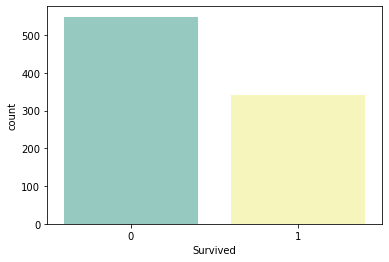

In [4]:
# Simple count plot
sns.countplot(data=data, x='Survived', palette='Set3')

<AxesSubplot:xlabel='Survived', ylabel='count'>

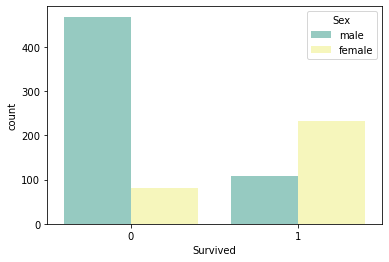

In [5]:
# Hued count plot
sns.countplot(data=data, hue='Sex', x='Survived', palette='Set3')

<AxesSubplot:xlabel='Pclass', ylabel='Embarked'>

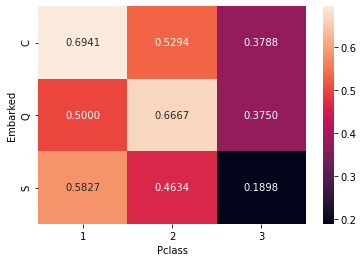

In [6]:
# Heat map
data_pvt = pd.pivot_table(data=data, index='Embarked', columns='Pclass', values='Survived', aggfunc='mean')
sns.heatmap(data_pvt, annot=True, fmt='.4f')

## Model

In [7]:
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.preprocessing import OneHotEncoder

n_splits, test_size, random_state = 5, 0.2, 23
cv = StratifiedShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=random_state)

In [8]:
# logistic regression
feat_cols = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
cat_cols = ['Sex', 'Embarked']

enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
cat_enc = pd.DataFrame(enc.fit_transform(data[cat_cols]), columns=enc.get_feature_names(cat_cols))
X = pd.concat([data[set(feat_cols) - set(cat_cols)], cat_enc], axis=1)
X['Age'].fillna(X['Age'].median(), inplace=True)

clf_ridge = RidgeClassifier()
score_ridge = cross_val_score(clf_ridge, X, data['Survived'], cv=cv, scoring='roc_auc')
print(f'ridge regression: F1 = {score_ridge.mean():.4f} +- {score_ridge.std():.4f}')

ridge regression: F1 = 0.8634 +- 0.0376


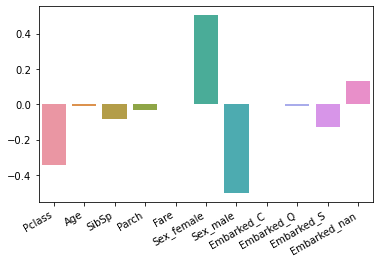

In [9]:
# feature importance
clf_ridge.fit(X, data['Survived'])
fig, ax = plt.subplots()
sns.barplot(x=X.columns, y=clf_ridge.coef_.ravel(), ax=ax)
fig.autofmt_xdate()

In [10]:
# lgb - import
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder


data_lgb = data.copy()
le_dict = {}
for c in cat_cols:
    le = LabelEncoder()
    data_lgb[c] = le.fit_transform(data_lgb[c])
    le_dict[c] = le

In [11]:
# lgb
lgb_clf = lgb.LGBMClassifier()
dtrain = lgb.Dataset(data=data_lgb[feat_cols], label=data_lgb['Survived'],
					 categorical_feature=cat_cols)
cv_results = lgb.cv(params=lgb_clf.get_params(), train_set=dtrain, folds=cv, verbose_eval=-1,
					metrics='auc')


C:\Users\waxi7003\Miniconda3\envs\generic_template\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\waxi7003\Miniconda3\envs\generic_template\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\waxi7003\Miniconda3\envs\generic_template\lib\site-packages\lightgbm\basic.py:1222: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.
  _log_warning('{0} keyword has been found in `params` and will be ignored.\n'


[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000184 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 224
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 7
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Auto-choo

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [12]:
print(f"score_lgb = {cv_results['auc-mean'][-1]:.4f} +- {cv_results['auc-stdv'][-1]:.4f}")

score_lgb = 0.8893 +- 0.0111


In [13]:
# lgb - sklearn style
lgb_clf = lgb.LGBMClassifier()
fit_params = {'categorical_feature': cat_cols}
score_lgb = cross_val_score(lgb_clf, data_lgb[feat_cols], data_lgb['Survived'], cv=cv,
							scoring='roc_auc', fit_params=fit_params)
print(f'score_lgb = {score_lgb.mean():.4f} +- {score_lgb.std():.4f}')

C:\Users\waxi7003\Miniconda3\envs\generic_template\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\waxi7003\Miniconda3\envs\generic_template\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\waxi7003\Miniconda3\envs\generic_template\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\waxi7003\Miniconda3\envs\generic_template\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


score_lgb = 0.8833 +- 0.0140


C:\Users\waxi7003\Miniconda3\envs\generic_template\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


In [14]:
# lgb + optuna
import optuna


param_fixed = {
    'objective': 'binary',
    'metric': 'auc',  # https://lightgbm.readthedocs.io/en/latest/Parameters.html
    'verbosity': -1,
    'boosting_type': 'gbdt'
}


def objective(trial):
    param_opt = {
        'max_depth': trial.suggest_int('bagging_freq', 3, 8),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256)
    }
    param = {**param_fixed, **param_opt}
    cv_results = lgb.cv(params=param, train_set=dtrain, folds=cv)
    return cv_results['auc-mean'][-1]


class EarlyStoppingCallback:
    def __init__(self, patience: int):
        self.patience = patience
        self._opt_loss = np.inf  # the smaller, the better!!!
        self._consecutive_no_improve_count = 0

    def __call__(self, study: optuna.study.Study, trial: optuna.trial.FrozenTrial) -> None:
        if study.best_trial.value < self._opt_loss:
            self._opt_loss = study.best_trial.value
            self._consecutive_no_improve_count = 0
        else:
            self._consecutive_no_improve_count += 1

        if self._consecutive_no_improve_count >= self.patience:
            print(f'There is no improvement after {self.patience} trials. '
				  f'Stop the parameter optimization with opt loss = {self._opt_loss:.4e}.')
            study.stop()

In [15]:
dtrain = lgb.Dataset(data=data_lgb[feat_cols], label=data_lgb['Survived'],
                     categorical_feature=cat_cols, free_raw_data=False)

early_stopping = EarlyStoppingCallback(patience=10)
study = optuna.create_study(direction='maximize')
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    study.optimize(objective, n_trials=100, callbacks=[early_stopping])

[I 2021-05-24 16:55:53,181] A new study created in memory with name: no-name-daeb3f95-834c-4fe9-b8ae-404a3882ee7f
[I 2021-05-24 16:55:53,525] Trial 0 finished with value: 0.8796706192358366 and parameters: {'bagging_freq': 7, 'learning_rate': 0.1828904544048467, 'lambda_l1': 3.0991603711626683e-06, 'lambda_l2': 0.22925736741515956, 'num_leaves': 55}. Best is trial 0 with value: 0.8796706192358366.
[I 2021-05-24 16:55:53,799] Trial 1 finished with value: 0.8846903820816865 and parameters: {'bagging_freq': 6, 'learning_rate': 0.1912708872348271, 'lambda_l1': 0.03353688470699208, 'lambda_l2': 1.6663691676859623e-05, 'num_leaves': 38}. Best is trial 1 with value: 0.8846903820816865.
[I 2021-05-24 16:55:54,110] Trial 2 finished with value: 0.8870750988142291 and parameters: {'bagging_freq': 6, 'learning_rate': 0.09887214056316532, 'lambda_l1': 6.295608263399439e-07, 'lambda_l2': 0.10160291300765832, 'num_leaves': 126}. Best is trial 2 with value: 0.8870750988142291.
[I 2021-05-24 16:55:54,3

There is no improvement after 10 trials. Stop the parameter optimization with opt loss = 8.7967e-01.


In [16]:
print('Number of finished trials: {}'.format(len(study.trials)))

print('Best trial:')
trial = study.best_trial

print('  Value: {}'.format(trial.value))

print('  Params: ')
for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

Number of finished trials: 11
Best trial:
  Value: 0.8932147562582345
  Params: 
    bagging_freq: 4
    learning_rate: 0.04067428818738968
    lambda_l1: 0.04303280775449754
    lambda_l2: 1.6774889954801715
    num_leaves: 229


C:\Users\waxi7003\Miniconda3\envs\generic_template\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


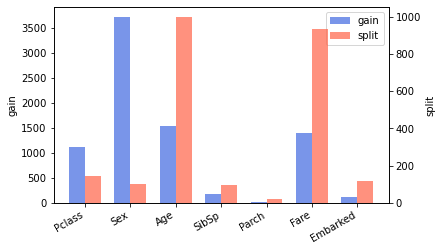

In [17]:
# feature importance - LGB
clf_lgb = lgb.train(params={**param_fixed, **trial.params}, train_set=dtrain)
feat_imp_split = clf_lgb.feature_importance(importance_type='split')
feat_imp_gain = clf_lgb.feature_importance(importance_type='gain')
feat_imp = pd.DataFrame({'feature': clf_lgb.feature_name(), 'gain': feat_imp_gain,
                         'split': feat_imp_split})

x = np.arange(len(feat_imp))
width = 0.35  # the width of the bars

fig, ax_gain = plt.subplots()
ax_split = ax_gain.twinx()
legend, labels, axes = [], ['gain', 'split'], [ax_gain, ax_split]
for ax, l, w, c in zip(axes, labels, [-width, width], ['royalblue', 'tomato']):
    rects = ax.bar(x, feat_imp[l], width=w, align='edge', label=l, color=c, alpha=0.7)
    legend.append(rects)
    ax.set_ylabel(l)
ax_gain.legend(legend, labels)
ax_gain.set_xticks(x)
ax_gain.set_xticklabels(feat_imp['feature'])
fig.autofmt_xdate()